### 0. Utilities

#### Imports

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from utils.maestri import (MAESTRI_ROLES, export_maestri, get_maestri_code_col,
                           load_maestri)
from utils.maestri.graphs import plot_scores_by_role, plot_scores_by_std
from utils.maestri.stats import get_similarity_matrix
from utils.maestri.validation import validate_maestri
from utils.types import IndustryStandard

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [2]:
# Read the MAESTRI dataset as a DataFrame
maestri_dfs = load_maestri()

In [3]:
maestri_dfs[0].head()

,Company description,NACE code,ISIC code,WZ code,SSIC code
Database ID,,,,,
"1,12,4",Refinery,1920,1920,19200,19201
"1,12,5",Refinery,1920,1920,19200,19201
"1,12,10",Steelworks,2410,2410,24520,24310
"1,12,11",Steelworks,2410,2410,24520,24310
"1,12,12",Cement production,2351,2394,23510;23650;23610,23940


### 2. Obtaining similarity scores for validation

In [4]:
maestri_dfs = validate_maestri(maestri_dfs)

In [5]:
maestri_dfs[0].head()

,Company description,NACE code,ISIC code,ISIC code sim. score,WZ code,WZ code sim. score,SSIC code,SSIC code sim. score
Database ID,,,,,,,,
"1,12,4",Refinery,1920,1920,1.0,19200,1.0,19201,1.0
"1,12,5",Refinery,1920,1920,1.0,19200,1.0,19201,1.0
"1,12,10",Steelworks,2410,2410,1.0,24520,0.0,24310,0.0
"1,12,11",Steelworks,2410,2410,1.0,24520,0.0,24310,0.0
"1,12,12",Cement production,2351,2394,1.0,23510;23650;23610,1.0,23940,0.0


### 3. Model performance statistics

#### Summary

In [10]:
get_similarity_matrix(maestri_dfs)

,s = -1,s = 0,0 < s < 1,s = 1
ISIC,0,28,0,640
WZ,0,258,29,381
SSIC,0,337,41,290


In [6]:
get_similarity_matrix(maestri_dfs, is_percent=True) * 100

,s = -1,s = 0,0 < s < 1,s = 1
ISIC,0.0,4.191617,0.000000,95.808383
WZ,0.0,38.622754,4.341317,57.035928
SSIC,0.0,50.449102,6.137725,43.413174


#### Visualising similarity scores

##### By company role and industry classification standard

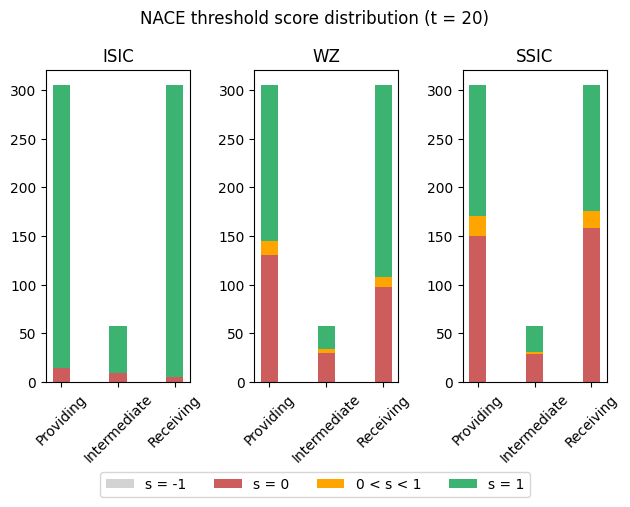

In [7]:
plot_scores_by_role(maestri_dfs)

##### By industry classification standard

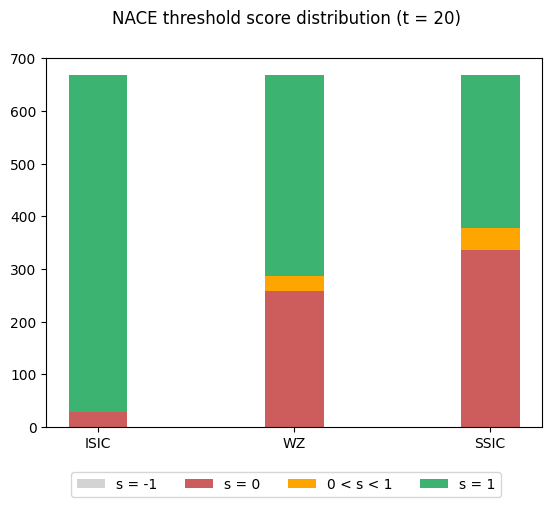

In [8]:
plot_scores_by_std(maestri_dfs)

### 4. Exporting results to Excel

In [9]:
export_maestri(maestri_dfs)